In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import shap
import lime
import lime.lime_tabular
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def standardize(non_binary_predictors, X_train, X_test=None):
    
    scaler = StandardScaler().fit(X_train[non_binary_predictors])
    
    # if x_test is passed in, or just x_train 
    if X_test is not None:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        X_test[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])
        return X_train, X_test, scaler
    else:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        return X_train, scaler
    
def normalize_data(X_train, X_test=None):
    scaler = MinMaxScaler()
    
    if X_test is not None:
        X_train_normalized = scaler.fit_transform(X_train)
        X_test_normalized = scaler.transform(X_test)
        return X_train_normalized,X_test_normalized
    else:
        X_train_normalized = scaler.fit_transform(X_train)
        return X_train_normalized

def split_and_standardize(df, x_cols, y_col, non_binary_preds, interact_cols=None,
                         s=True, n=False, shuffle=False):
        
    # split into train and test
    zips = np.unique(df.zip)
    zips_test = list(np.random.choice(zips, round(zips.shape[0]*.25)))
    zips_train  = [x for x in zips if x not in zips_test]
    
    if shuffle:
        df_train = df[df.zip.isin(zips_train)].sample(frac=1)
        df_test = df[df.zip.isin(zips_test)]
    else:
        df_train = df[df.zip.isin(zips_train)]
        df_test = df[df.zip.isin(zips_test)]
    
    
    # separate into X and y
    X_train, y_train = df_train[x_cols],df_train[y_col]
    X_test, y_test = df_test[x_cols],df_test[y_col]
    
#     X, y = df[x_cols],df[y_col]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=109)
    
    # standardize
    if s==True:
        X_train_standardized, X_test_standardized, scaler = standardize(non_binary_preds, X_train, X_test)
        return X_train_standardized, y_train, X_test_standardized, y_test, scaler
        
    
    elif n==True:
        X_train_normalized, X_test_normalized = normalize_data(X_train[non_binary_preds], 
                                                                X_test[non_binary_preds])
        return X_train_normalized, y_train, X_test_normalized, y_test
    
    else:
        return X_train, y_train, X_test, y_test

def split_and_standardize2(df, x_cols, y_col, non_binary_preds, interact_cols=None,
                         s=True,shuffle=True):
        
    # split into train and test
    zips = np.unique(df.zip)
    train_ind, test_ind = train_test_split(range(zips.shape[0]), test_size=0.25,shuffle=True)
    zips_train  = zips[train_ind]
    zips_test = zips[test_ind]
    # shuffling so same zips are not close to eachother
    df_train  = df[df.zip.isin(zips_train)].sample(frac=1)
    df_test = df[df.zip.isin(zips_test)]
    
    # separate into X and y
    X_train, y_train = df_train[x_cols],df_train[y_col]
    X_test, y_test = df_test[x_cols],df_test[y_col]
        
    # standardize
    if s==True:
        X_train_standardized, X_test_standardized, scaler = standardize(non_binary_preds, X_train, X_test)
        return X_train_standardized, y_train, X_test_standardized, y_test, scaler
    else:
        return X_train, y_train, X_test, y_test
    

def build_gbr_model(params):
    lr = params['lr']
    n_trees = params['n_trees']
    max_depth = params['max_depth']
    sprop = params['sprop']
    max_feats='sqrt'
    
    gbr_model = GradientBoostingRegressor(learning_rate=lr,
                                      n_estimators=n_trees,
                                      max_depth=max_depth,
                                      subsample=sprop,
                                      max_features=max_feats,
                                     loss='ls')
    return gbr_model

def build_rf_model(params):
    n_trees = params['n_trees']
    max_depth = params['max_depth']
    max_feats='auto'

    rf_model = RandomForestRegressor(n_estimators=n_trees,max_depth= max_depth, 
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features=max_feats,
                                  bootstrap=True)
    return rf_model

def check_robustness(df_train, x_col, y_col, params, build_gbr_model):

    train_scores = []
    test_scores = []
    train_mse = []
    test_mse = [] 
    non_binary_preds = x_col
    train_preds = []
    test_preds = []
              
    for i in range(10):
        # resample and shuffle
        X_train_standardized, y_train, X_test_standardized, y_test, s = split_and_standardize2(df_train, x_col, y_col, non_binary_preds, shuffle=True)
        
        # build gbr
        model = build_gbr_model(params)
        
        # fit and predict
        model.fit(X_train_standardized, y_train)
        gbr_test_pred = model.predict(X_test_standardized)  
        gbr_train_pred = model.predict(X_train_standardized)  
        
        train_scores.append(model.score(X_train_standardized, y_train))
        test_scores.append(model.score(X_test_standardized, y_test))
        print(train_scores[-1],test_scores[-1])
        
        train_mse.append(mean_squared_error(y_train, gbr_train_pred))
        test_mse.append(mean_squared_error(y_test, gbr_test_pred))
        train_preds.append(gbr_train_pred)
        test_preds.append(gbr_test_pred)
        print('completed round')
                    
    return train_scores, test_scores, train_mse, test_mse, train_preds, test_preds

def explain_local(X_train_standardized, X_test_standardized, x_col, model, i,n):
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train_standardized.values, feature_names = x_col,
                                                   class_names=['deaths_next_year'],
                                                   mode='regression')
    
    exp = explainer.explain_instance(X_test_standardized.loc[[i]].values[0], model.predict, num_features=n)
    exp.show_in_notebook(show_table=True)
    return exp

def plot_lime(exp_weights,y_tick_labs,title,colors,save_lab,xlim=(-100,30)):
    f,ax = plt.subplots(1,figsize=(12,8))
    hbars = ax.barh(range(len(exp_weights)),exp_weights,color=colors)
    ax.invert_yaxis()
    
    ax.set_yticks(range(len(exp_weights)))
    ax.set_yticklabels(y_tick_labs, fontsize=15)
    ax.set_xlabel('Weights', fontsize=20)
    ax.set_xlim(xlim)
    
    # Label with specially formatted floats
    for i, v in enumerate(exp_weights):
        if v < 0:
            ax.text(v - 8, i + 0.25, str(round(v,2)), color='black', fontweight='bold', fontsize=10)
        else:
            ax.text(v + 1, i + 0.25, str(round(v,2)), color='black', fontweight='bold',fontsize=10)
    
    plt.title(title, fontsize=25)
    plt.tight_layout()
    plt.savefig(save_lab,dpi=300) 
    plt.show()

In [5]:
df_train = pd.read_csv('data/zip_train_yearly.csv').drop(columns=['Unnamed: 0'])
df_test= pd.read_csv('data/zip_test_yearly.csv').drop(columns=['Unnamed: 0'])

In [6]:
corr, _ = pearsonr(df_train['CVD_pdx2dx_25'],df_train['DM_pdx2dx_25'])
corr

0.9679017787503752

In [1]:
hosps = ['CVD_pdx2dx_25',
        'COPD_pdx2dx_25', 'DM_pdx2dx_25',
       'Stroke_pdx2dx_25',  'malignant_neoplasms']

labs=['CVD',
        'COPD', 'Diabetic',
       'Stroke','Malignant Neoplasms']

corrMatrix = df_train[hosps].corr()
f,ax = plt.subplots(1,figsize=(15,10))
sns.heatmap(corrMatrix, annot=True,ax=ax,yticklabels=labs)
ax.set_xticklabels(labs,rotation=35)
ax.set_yticklabels(labs,rotation=0)
plt.title('Pearson Correlation Coefficient Among Cause-Specific Hospitalizations',fontsize=17)
plt.savefig('EDA/hosp_corr2.png',dpi=300)
plt.show()

In [2]:
hosps = ['ICU_DAY', 'CCI_DAY', 'LOS','CVD_pdx2dx_25',
       'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25',
        'COPD_pdx2dx_25', 'DM_pdx2dx_25',
       'Stroke_pdx2dx_25',  'neo_210_229', 'malignant_neoplasms']

labs=['ICU Days', 'CCI Days', 'LOS','CVD',
       'Parkinson', 'Alzheimer', 'Dementia',
        'COPD', 'Diabetic',
       'Stroke','Bengign Neoplasms', 'Malignant Neoplasms']

corrMatrix = df_train[hosps].corr()
f,ax = plt.subplots(1,figsize=(15,10))
sns.heatmap(corrMatrix, annot=True,ax=ax,yticklabels=labs)
ax.set_xticklabels(labs,rotation=35)
plt.title('Pearson Correlation Coefficient Among Cause-Specific Hospitalizations',fontsize=17)
plt.savefig('EDA/hosp_corr.png',dpi=300)
plt.show()

In [3]:
df_train2 = df_train.copy()
cs = ['year_2011','year_2012','year_2013','year_2014','year_2015']

for i,y in enumerate(range(2011,2016)):
    df_train2[cs[i]] = 0
    y_ind = list(df_train2[df_train2['AYEAR']==int(y)].index.values)
    df_train2[cs[i]][y_ind] = 1

# df_train2[cs].head(5)

In [8]:
# all categories of cvd: chf,  ischemic stroke,heart attack, heart disease
# source: https://www.heart.org/en/health-topics/consumer-healthcare/what-is-cardiovascular-disease
cs = ['year_2011','year_2012','year_2013','year_2014','year_2015']
non_binary_preds = ['sex','mean_age','population',
       'poverty',  'medianhousevalue', 
       'medhouseholdincome', 'pct_owner_occ',  'education',
       'smoke_rate', 'mean_bmi', 'race_1', 'race_2','race_3', 'race_4', 'race_5', 'race_6',
        'ICU_DAY', 'CCI_DAY', 'LOS',
       'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25',
       'COPD_pdx2dx_25', 'DM_pdx2dx_25',
       'Stroke_pdx2dx_25', 'CVD_pdx2dx_25', 'neo_210_229',
        # 'neo_140_149','neo_190_199', 'neo_200_209', 'neo_230_234',
#        'neo_150_159', 'neo_160_165', 'neo_170_176', 'neo_179_189',
       #'neo_235_238', 'neo_239', 
        'malignant_neoplasms',
        'pm25_summer_4y_avg', 'pm25_winter_4y_avg', 
       'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
       'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
       'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
       'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
       'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

x_col = non_binary_preds + cs
y_col = 'deaths_next_year'

# split into train and test and standardize
X_train_standardized, y_train, X_test_standardized, y_test, scaler1 = split_and_standardize2(df_train2, x_col, y_col, non_binary_preds)

# split into train and test and not standardize - not needed for tree models
X_train2, y_train2, X_test2, y_test2 = split_and_standardize2(df_train2, x_col,y_col, non_binary_preds, s=False)

**Bagging**

In [9]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):

    #n_depths = len(tree_depth)
    np.random.seed(random_seed)
    bagging_train = np.zeros((X_train_standardized.shape[0], n_trees))
    bagging_test = np.zeros((X_test_standardized.shape[0], n_trees))

    bagging_models = []

    for i in range(n_trees):
        bootstrapped_X, bootstrapped_y = resample(X_train_standardized, y_train)
        fitted_model = DecisionTreeRegressor(max_depth=tree_depth).fit(bootstrapped_X, bootstrapped_y)
        bagging_models.append(fitted_model)

        bagging_train[:,i] = fitted_model.predict(X_train_standardized)
        bagging_test[:,i] = fitted_model.predict(X_test_standardized)
    
    return  pd.DataFrame(bagging_train[:,:], columns=[f"model{x}" for x in range(n_trees)]) \
        , pd.DataFrame(bagging_test[:,:], columns=[f"model{x}" for x in range(n_trees)]) \
        , bagging_models

In [10]:
n_trees = 30 
tree_depth = 10
bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth,  random_seed= 0)
display(bagging_train_df.head())
display(bagging_test_df.head())

model0      model1      model2      model3      model4      model5  \
0  135.139896  116.373494  134.757895  121.671698  113.364583  116.763359   
1   23.028571   20.582418   16.325301   21.824675   28.590909   19.512397   
2   84.916350   97.253425   77.916667   96.971098  102.565217   81.896714   
3  172.415584  180.500000  214.444444  237.864865  188.564516  213.163636   
4   55.425856   54.592777   67.740741   60.991667   56.702756   60.894309   

       model6      model7      model8      model9  ...     model20  \
0   93.439883  109.791667  109.734375  121.817391  ...  136.108333   
1   20.016667   19.937352   19.307536   28.922078  ...   20.311475   
2   85.932203   98.523810  102.114458   95.933824  ...   78.659091   
3  180.886598  194.705882  179.919192  201.089552  ...  187.404494   
4   61.679699   58.935961   56.401818   65.910638  ...   50.937402   

      model21     model22     model23     model24     model25     model26  \
0   97.000000  123.174658   87.725000   88.179856  112.504348   91.214485   
1   22.131148   23.274725   20.148810   26.357143   21.710084   26.068966   
2   90.153061   92.139831   94.580952  103.208333   94.816547   95.197183   
3  202.310811  202.918478  194.720238  196.212687  225.855422  254.534884   
4   55.348837   57.402715   48.588235   59.410138   58.553719   60.816092   

      model27     model28     model29  
0  116.500000  107.489583  124.272000  
1   23.549342   18.077754   13.733333  
2   94.523810   94.479167  100.958763  
3  183.578125  210.586207  222.783133  
4   58.719192   54.038943   60.454545  

[5 rows x 30 columns]

model0      model1     model2     model3      model4      model5  \
0  99.808511   87.052239  91.632075  96.893443  106.223881   96.921053   
1  99.808511   87.052239  91.632075  96.893443  106.223881   96.921053   
2  85.782123  113.619048  74.209016  78.832258   81.024096   96.921053   
3  85.782123  113.619048  74.209016  78.832258   81.024096   96.921053   
4  82.901639  113.619048  90.217949  96.502618   85.024129  120.100000   

       model6     model7     model8     model9  ...     model20    model21  \
0  106.162500  80.058824  65.043478  78.068657  ...  104.602041  96.257457   
1  100.263889  80.058824  48.666667  78.068657  ...  107.959596  96.257457   
2  106.162500  67.504950  48.666667  78.068657  ...   87.612766  95.333333   
3  100.263889  67.504950  48.666667  84.405941  ...   87.612766  95.333333   
4  100.263889  93.382609  88.289474  84.405941  ...   87.612766  81.666667   

     model22    model23    model24    model25     model26    model27  \
0  86.489583  89.529801  96.718447  97.020548  114.075758  95.093333   
1  86.489583  79.197731  96.718447  97.020548  114.075758  94.653333   
2  92.139831  79.197731  80.432739  79.896825  106.296296  75.631783   
3  92.139831  95.273684  80.432739  79.896825  106.296296  94.653333   
4  92.139831  95.273684  80.432739  79.896825   79.060377  94.653333   

     model28     model29  
0  91.027907   87.592593  
1  91.027907   73.377358  
2  91.027907   73.377358  
3  91.027907   84.238462  
4  86.444444  111.588235  

[5 rows x 30 columns]

In [11]:
bagging_train_pred = np.mean(bagging_train_df, axis=1) 
bagging_test_pred = np.mean(bagging_test_df, axis=1)

bagging_accuracy_train = r2_score(y_train, bagging_train_pred)
bagging_accuracy_test = r2_score(y_test, bagging_test_pred)

print(f"Bagging {n_trees} of depth {tree_depth} achieved a score of {bagging_accuracy_train} on the train set.")
print(f"Bagging {n_trees} of depth {tree_depth} achieved a score of {bagging_accuracy_test} on the test set.")

Bagging 30 of depth 10 achieved a score of 0.9513123306508984 on the train set.
Bagging 30 of depth 10 achieved a score of 0.912004422211931 on the test set.


In [12]:
top_predictors_bagging = [X_train_standardized.columns[model.tree_.feature[0]] for model in bagging_models]
top_predictors_bagging_df = pd.DataFrame(pd.Series(top_predictors_bagging).value_counts(), columns=['Count'])
display(top_predictors_bagging_df)

Count
CVD_pdx2dx_25     30

**Random Forest Regression**


In [13]:
# grid search and cross validation on random forest
# https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

# VISUALIZE TREE
# https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

# figure out how to parallelize RF 

In [14]:
# gsr = GridSearchCV(
#         estimator = RandomForestRegressor(),
#         param_grid={'max_depth': range(10,15),'n_estimators': (30,40,50,60)})#,
# #         cv=5)

# gsr_fitted = gsr.fit(X_train_standardized, y_train)
# best_params = gsr_fitted.best_params_

In [13]:
# number of trees
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 15)]

# number of features to consider at each aplit
max_feats = ['auto','sqrt']

# max depth of each tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# min number of samples required to split node
min_samples_split = [2,5,10]

# min number of samples required at each node
min_samples_leaf = [1,2,4]

# method of selecting samples for training a tree
bootstrap = [True, False]

random_grid = {
    'n_estimators':n_estimators,
    'max_features': max_feats,
    'max_depth': max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap': bootstrap
}
print(random_grid)

{'n_estimators': [20, 90, 160, 230, 300, 370, 440, 510, 580, 650, 720, 790, 860, 930, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [8]:
# first conduct random grid search to see where to focus our grid search cv on
rf = RandomForestRegressor()

# random search accross 100 different combos
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter=25, cv=3, verbose=2, 
                              random_state=42,
                              n_jobs=-1)

# fit random search model
rf_random.fit(X_train_standardized, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  75 | elapsed:   52.4s remaining: 31.9min
[Parallel(n_jobs=-1)]: Done  40 out of  75 | elapsed: 11.6min remaining: 10.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 49.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 90, 160, 230, 300,
                                                         370, 440, 510, 580,
                                                         650, 720, 790, 860,
                                                         930, 1000]},
                   random_state=42, verbose=2)

In [10]:
rf_random.best_params_

{'n_estimators': 230,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [13]:
# base_model = RandomForestRegressor(n_estimators=230,max_depth=100,
#                                   min_samples_split=2,
#                                   min_samples_leaf=1,
#                                   max_features='auto',
#                                   bootstrap=True)
# base_model.fit(X_train_standardized, y_train)

# # base_rf_train_preds = base_model.predict(X_train_standardized)
# # base_rf_test_preds = base_model.predict(X_test_standardized)

# print(base_model.score(X_train_standardized, y_train))
# print(base_model.score(X_test_standardized, y_test))

In [ ]:
param_grid2 = {
    'bootstrap': [True],
    'max_depth': [100, 120, 150],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [250, 300, 350, 400]
}

# Create a based model
rf2 = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf2, param_grid = param_grid2, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_standardized, y_train)
grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


In [17]:
best_model = RandomForestRegressor(n_estimators=350,max_depth= 150, #350, 100,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features='auto',
                                  bootstrap=True)
best_model.fit(X_train_standardized, y_train)

print(best_model.score(X_train_standardized, y_train))
print(best_model.score(X_test_standardized, y_test))

0.9940177056964993
0.9172510365800048


In [18]:
cols = X_train_standardized.columns
best_top_pred = [cols[best_model.estimators_[i].tree_.feature[0]] for i in range(100)]

pd.DataFrame(pd.Series(best_top_pred).value_counts(), columns=['Counts'])

Counts
CVD_pdx2dx_25     100

In [19]:
best_rf_train_preds = best_model.predict(X_train_standardized)
best_rf_test_preds = best_model.predict(X_test_standardized)

print(mean_squared_error(y_test, best_rf_test_preds))
print(mean_squared_error(y_test, best_rf_test_preds, squared=False))
print(mean_absolute_error(y_test, best_rf_test_preds))

644.0804960817153
25.37874102633374
16.020589665653496


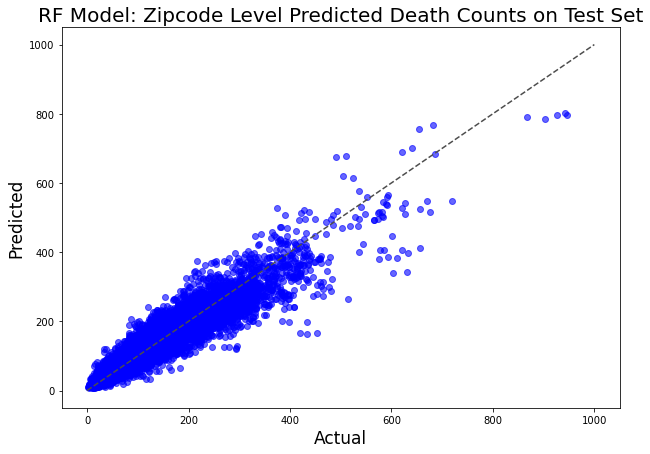

In [20]:
plt.figure(figsize=(10,7))
plt.scatter(y_test,best_rf_test_preds,color='blue',alpha=0.6) 
plt.plot([0, 1000], [0, 1000], ls="--", c=".3")
plt.title("RF Model: Zipcode Level Predicted Death Counts on Test Set", fontsize=20)
plt.ylabel("Predicted", fontsize=17)
plt.xlabel("Actual", fontsize=17)
# plt.savefig('rf_performance.png')
plt.show()

In [115]:
rf_params = {'n_trees':400,
          'max_depth':150,
          'max_feats':'auto'}

rf_train_r2s, rf_test_r2, rf_train_mse, rf_test_mse,rf_train_preds, rf_test_preds = check_robustness(df_train2, x_col,y_col,rf_params,build_rf_model)

0.993997077474699 0.9243892693586724
completed round
0.9940908440487957 0.917682589027717
completed round
0.9940580387077472 0.9249609180384003
completed round
0.9941021356343293 0.9195635870479594
completed round
0.9940679695313743 0.9188222512227782
completed round
0.9941241318418053 0.9217018587058353
completed round
0.9940659547144994 0.9207979386115165
completed round
0.9940691046981432 0.9204824453627647
completed round
0.9941170954183731 0.9220752458845496
completed round
0.9941231465167905 0.9215578154597107
completed round


In [116]:
labs = ['rf train r2','rf test r2','rf train mse','rf test mse']
for i,s in enumerate([rf_train_r2s, rf_test_r2, rf_train_mse, rf_test_mse]):
    print(labs[i],' : ',np.mean(s))

print('rf rmse : ',np.mean([np.sqrt(i) for i in rf_test_mse]))
print('rf r2 std : ',np.std(rf_test_r2))
print('rf mse std :',np.std(rf_test_mse))
print('(min,max r2): ',np.min(rf_test_r2),np.max(rf_test_r2))
print('(min,max mse): ',np.min(rf_test_mse),np.max(rf_test_mse))

rf train r2  :  0.9940815498586556
rf test r2  :  0.9212033918719904
rf train mse  :  47.159087440893344
rf test mse  :  610.1117896404191
rf rmse :  24.69642686690205
rf r2 std :  0.002164302023070648
rf mse std : 21.813355163430913
(min,max r2):  0.917682589027717 0.9249609180384003
(min,max mse):  567.8731774775202 638.1546604720745


In [4]:
print(pd.DataFrame([np.sqrt(i) for i in rf_test_mse]).describe(), '\n')
print(pd.DataFrame(rf_test_mse).describe(), '\n')
print(pd.DataFrame(rf_test_r2).describe(), '\n')

In [23]:
rf_train_pred_df = pd.DataFrame(np.array(rf_train_preds))
rf_test_pred_df = pd.DataFrame(np.array(rf_test_preds))
rf_train_pred_df.to_csv("rf_robust_train_preds.csv")
rf_test_pred_df.to_csv("rf_robust_test_preds.csv")

In [5]:
# rf_result = permutation_importance(best_model, X_test_standardized, y_test, n_repeats=5,
#                                 random_state=42, n_jobs=2)

ys = ['CVD','Population','Age','Summer PM2.5',
      'Race: White','Owner Occ (%)','Race: Hispanic',
      'Winter Temp (K)','Race: Other', 'Spring Ozone',
      'Summer Temp (K)','COPD', 'Winter Ozone','Med House Income',
      'Smoke Rate','Incomplete Education (%)','Race: Black',
     'Stroke','Summer Ozone', 'Spring PM_{2.5}']

sorted_idx2 = rf_result.importances_mean.argsort()
plt.subplots(1,figsize=(12,8))
plt.boxplot(rf_result.importances[sorted_idx2].T[:,-20:],
            vert=False, labels=ys[::-1]) # labels=np.array(X_test_standardized.columns)[sorted_idx2][-20:]) #
plt.title("RF Permutation Importance (Test Set)",fontsize=20)
plt.tight_layout()
plt.savefig('data/rf_perm_importance.png')
plt.show()

In [6]:
# ys = ['CVD','Stroke','Parkinson','Diabetic','MN: Unspecified',
#       'Alzheimers','COPD','Dementia',
#      'MN: Lymphatic', '# of ICU Days','Summer PM2.5',
#       'MN: Genitourinary','popdensity','Winter Temp','Age']

ys = ['CVD','Population','Age','Summer PM2.5',
      'Race: White','Owner Occ (%)','Summer Temp (K)',
      'Winter Temp (K)','Race: Black','Race: Hispanic', 'Spring Ozone',
      'Race: Other','Med House Income',
      'Smoke Rate', 'Winter Ozone','Spring PM_{2.5}','Incomplete Education (%)','Fall Ozone',
     'Winter RH','Female']

pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.barh(pos[-20:], best_feature_importance[sorted_idx][-20:], align='center')
plt.yticks(pos[-20:], ys[::-1])#np.array(X_test_standardized.columns)[sorted_idx][-20:]
plt.title('RF Feature Importance (Test Set)',fontsize=20)
plt.tight_layout()
plt.savefig('data/rf_feature_importance.png')
plt.show()

Gradient Boosting (Regressor)

https://blog.paperspace.com/implementing-gradient-boosting-regression-python/

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [19]:
# Create a based model
# gbr1 = GradientBoostingRegressor()

# param_grid_gbr = {
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [4,6,8],
#     'max_features': ['sqrt',],
#     'n_estimators': [300, 400, 500],
#     'subsample':[0.5,0.8,1]
# }

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = gbr1, param_grid = param_grid_gbr, 
#                           cv = 5, n_jobs = -1, verbose = 2)

# # Fit the grid search to the data
# grid_search.fit(X_train_standardized, y_train)
# grid_search.best_params_

In [39]:
# X_train_sub, y_train_sub, X_test_sub, y_test_sub
gbr_model = GradientBoostingRegressor(learning_rate=0.1,
                                      n_estimators=400,
                                      max_depth=6,
                                      subsample=1,
                                      max_features='sqrt',
                                     loss='ls')

gbr_model.fit(X_train_standardized, y_train) # x_train_standardized, y_train2

GradientBoostingRegressor(max_depth=6, max_features='sqrt', n_estimators=400,
                          subsample=1)

In [40]:
print(gbr_model.score(X_train_standardized, y_train))
print(gbr_model.score(X_test_standardized, y_test))

0.9797778078042045
0.938631096583924


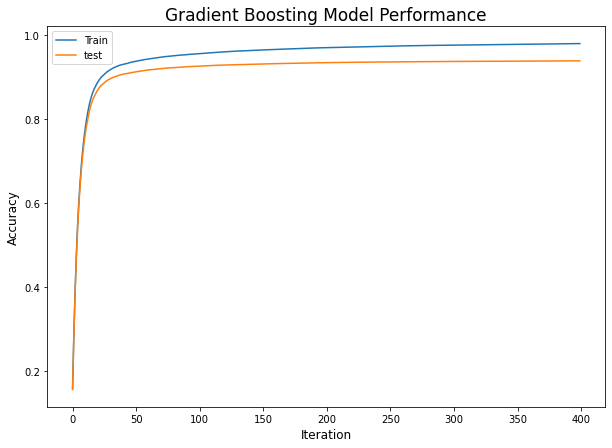

In [41]:
gbr_train_score = np.zeros((400,), dtype=np.float64)
for i, y_pred in enumerate(gbr_model.staged_predict(X_train_standardized)):
    gbr_train_score[i] = r2_score(y_train, y_pred)
    
gbr_test_score = np.zeros((400,), dtype=np.float64)
for i, y_pred in enumerate(gbr_model.staged_predict(X_test_standardized)):
    gbr_test_score[i] = r2_score(y_test, y_pred)

f, ax = plt.subplots(1, figsize=(10,7))
ax.plot(gbr_train_score,label='Train')
ax.plot(gbr_test_score,label='test')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title("Gradient Boosting Model Performance", fontsize=17)
plt.legend()
# f.savefig('gbr_results.png')
plt.show()

In [42]:
gbr_train_pred = gbr_model.predict(X_train_standardized)
gbr_test_pred = gbr_model.predict(X_test_standardized)

print(mean_squared_error(y_test, gbr_test_pred))
print(mean_squared_error(y_test, gbr_test_pred, squared=False))
print(mean_absolute_error(y_test, gbr_test_pred))

477.667781233693
21.85561212214595
14.02527435913668


In [44]:
gbr_test_pred[gbr_test_pred <0].shape[0]/gbr_test_pred.shape[0]

0.00025329280648429586

In [45]:
gbr_test_pred[gbr_test_pred <0]

array([-0.34115873, -1.74129808, -1.14482712, -0.3367143 , -1.84393066])

In [47]:
len(gbr_test_pred)

19740

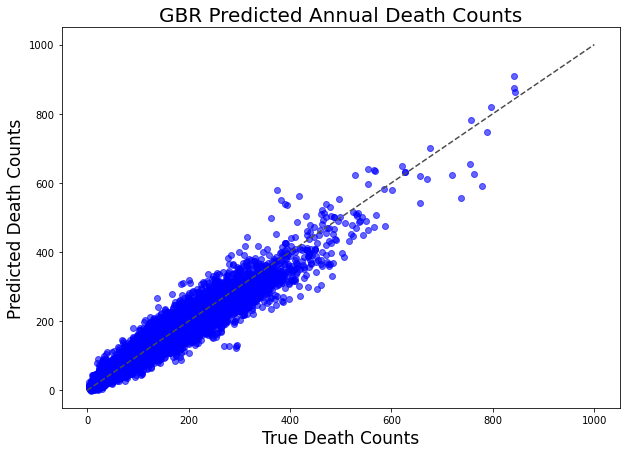

In [25]:
# note death is shifted, so must plot actual - year prior
gbr_test_score = gbr_model.score(X_test_standardized, y_test)

plt.figure(figsize=(10,7))
plt.scatter(y_test,gbr_test_pred,color='blue',alpha=0.6) 
plt.plot([0, 1000], [0, 1000], ls="--", c=".3")
plt.title("GBR Predicted Annual Death Counts",fontsize=20)#+ ': $R^2$=' + str(np.round(gbr_test_score,4)), fontsize=20)
plt.ylabel("Predicted Death Counts", fontsize=17)
plt.xlabel("True Death Counts", fontsize=17)
plt.savefig('plots/tree_methods/gbr_pred.png')
plt.show()

GBR LIME Model

In [26]:
gbr_lime = GradientBoostingRegressor(learning_rate=0.1,
                                      n_estimators=400,
                                      max_depth=6,
                                      subsample=1,
                                      max_features='sqrt',
                                     loss='ls')

gbr_lime.fit(X_train2, y_train2) 

GradientBoostingRegressor(max_depth=6, max_features='sqrt', n_estimators=400,
                          subsample=1)

In [29]:
i = 9465
n=10

gbr_lime_ls = explain_local(X_train2, X_test2, x_col, gbr_lime, i,n)

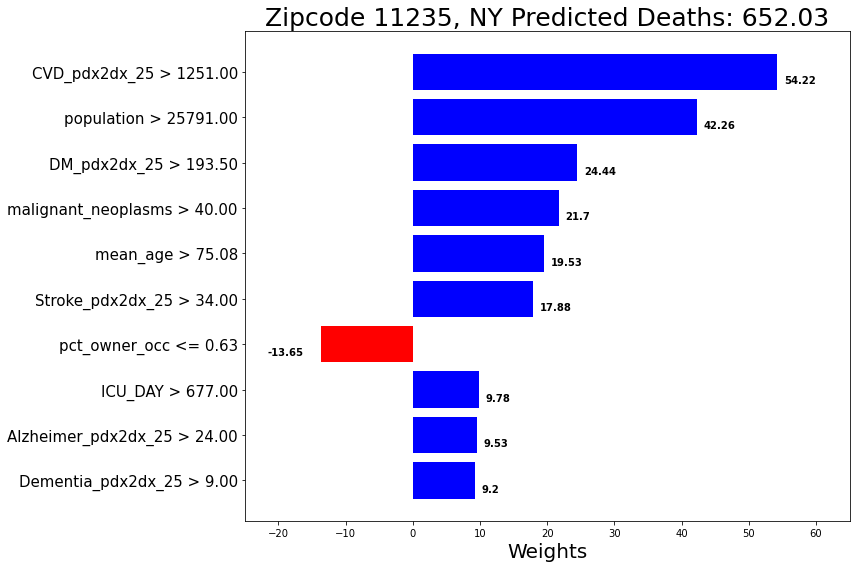

In [31]:
# get labels
lime_preds = ['CVD_pdx2dx_25','population','DM_pdx2dx_25',
              'malignant_neoplasms','mean_age',
              'Stroke_pdx2dx_25','pct_owner_occ',
              'ICU_DAY','Alzheimer_pdx2dx_25','Dementia_pdx2dx_25']

ind = df_train2.loc[i,:][lime_preds].index
vals = df_train2.loc[i,:][lime_preds].values
# gbr_labels_high = [lime_cols[i]+ ': '+str(round(vals[i],2)) for i in range(10)]
gbr_labels_high = [i[0] for i in gbr_lime_ls.as_list()]

# get lime weights
gbr_lime_high = gbr_lime_ls.as_list()
gbr_weights_high = [gbr_lime_high[i][1] for i in range(len(gbr_lime_high))]

colors = []
for j in gbr_weights_high:
    if j <  0:
        colors.append('red')
    else:
        colors.append('blue')

title='Zipcode '+ str(df_train2.loc[[i]].zip.values[0]) +', '+ df_train2.loc[[i]].statecode.values[0] + ' Predicted Deaths: '+ str(round(gbr_lime_ls.predicted_value,2))
save_lab='plots/tree_methods/gbr_lime_high_v2.png'
xlim=(-25,65)
plot_lime(gbr_weights_high,gbr_labels_high,title,colors,save_lab,xlim)


In [7]:
# df_train2.loc[list(X_test2[y_test2<=4].index.values),:]

In [33]:
i =11011
n=10
gbr_lime_ls_low = explain_local(X_train2, X_test2, x_col, gbr_lime, i,n)

In [53]:
gbr_lime_ls_low.as_list()

[('CVD_pdx2dx_25 <= 274.00', -34.38380265483369),
 ('population <= 4793.50', -22.701102252383567),
 ('mean_age <= 73.66', -15.681999889463324),
 ('DM_pdx2dx_25 <= 43.00', -12.05945326680526),
 ('malignant_neoplasms <= 9.00', -10.900818851588806),
 ('Stroke_pdx2dx_25 <= 7.00', -9.16967169254606),
 ('year_2011 <= 0.00', 8.661643810273459),
 ('summer_tmmx_4y_avg <= 301.00', 7.691328321741303),
 ('COPD_pdx2dx_25 <= 30.00', -6.481256846618521),
 ('ICU_DAY <= 127.00', -6.071605381727683)]

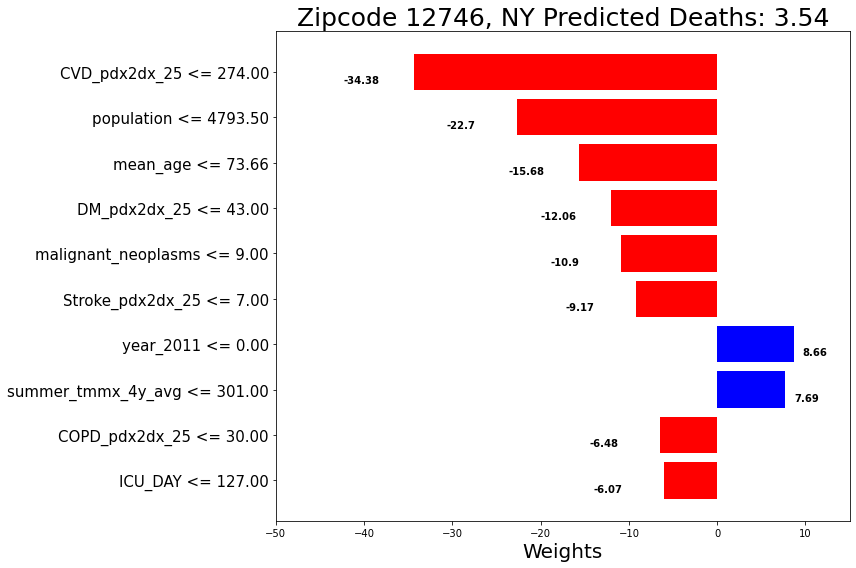

In [54]:
lime_low_preds = ['CVD_pdx2dx_25','population','mean_age',
                  'DM_pdx2dx_25','malignant_neoplasms',
                  'Stroke_pdx2dx_25','year_2011',
                  'summer_tmmx_4y_avg',
                  'COPD_pdx2dx_25','ICU_DAY']

ind2 = df_train2.loc[i,:][lime_low_preds].index
vals2 = df_train2.loc[i,:][lime_low_preds].values
# gbr_labels_low = [lime_cols2[i]+ ': '+str(round(vals2[i],2)) for i in range(10)]
gbr_labels_low = [i[0] for i in gbr_lime_ls_low.as_list()]

# get lime weights
gbr_lime_low = gbr_lime_ls_low.as_list()
gbr_weights_low = [gbr_lime_low[i][1] for i in range(len(gbr_lime_low))]
i=11011
colors = []
for j in gbr_weights_low:
    if j <  0:
        colors.append('red')
    else:
        colors.append('blue')

title='Zipcode '+ str(df_train2.loc[[i]].zip.values[0]) +', '+ df_train2.loc[[i]].statecode.values[0]+' Predicted Deaths: ' + str(round(gbr_lime_ls_low.predicted_value,2))
save_lab='plots/tree_methods/gbr_lime_low_v2.png'
xlim=(-50,15)
plot_lime(gbr_weights_low,gbr_labels_low,title,colors,save_lab,xlim)

GBR Feature Importance and robustnness

In [35]:
def find_high_deaths(df_test, model, x_col, n):
    final_X_test,scaler_x = standardize(x_col, df_test[x_col])
    final_y_test = df_test['deaths_next_year']
    final_test_pred = model.predict(final_X_test)
    df_test['death_pred'] = final_test_pred
    df_test['change_in_deaths'] = ((df_test.death_pred - df_test.death) / df_test.death).values
    high_deaths = df_test.sort_values(by='death_pred', ascending=False)[:n]
    return high_deaths

# find_high_deaths(df_test,gbr_model, x_col, n)
# races = ['race_2','race_4','race_5','race_6']
# high_deaths[['statecode','zip','death_pred','death', 'age', 'popdensity', 'CVD_pdx2dx_25']+races]
# i = 1
# for c in x_col:
#     if (high_deaths[c].mean() - df_test[c].mean())/high_deaths[c].mean() > 0.3:
#         i+=1
#         print(c)
#         print(high_deaths[c].mean(), df_test[c].mean(), '\n')

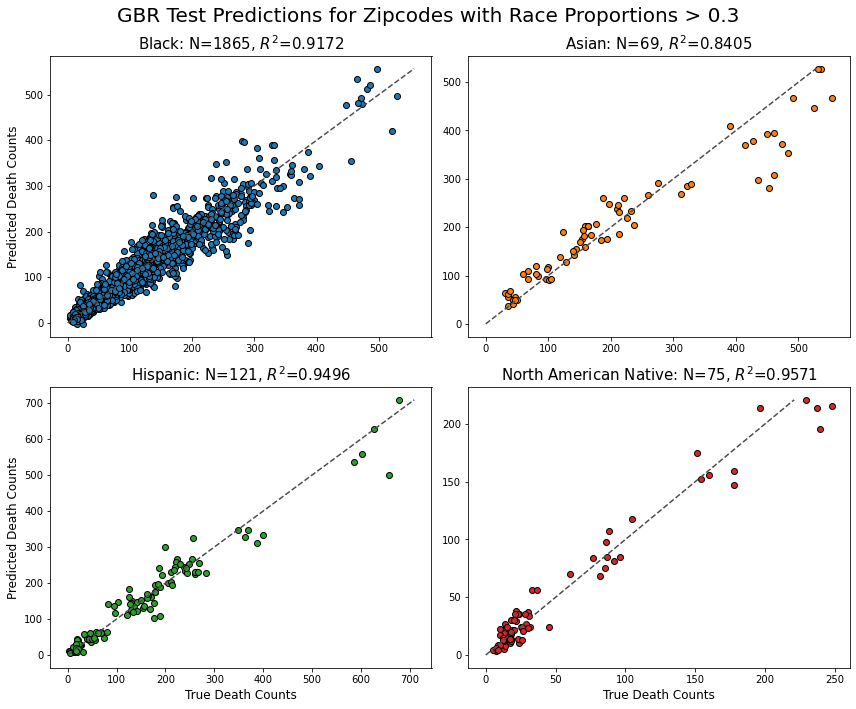

In [36]:
races = ['race_2','race_4','race_5','race_6']
race_names = [ 'Black','Asian','Hispanic','North American Native']
race_dfs = []
preds = []
true = []
r2_scores = []
n = []

# get index of X_test set and groupby zipcode - predict on average (over 5 years)
df_test2 = df_train2.loc[list(X_test_standardized.index)]
# df_test2_means = df_test2.groupby(['zip']).mean()

for i,race in enumerate(races):
    df = df_test2[df_test2[race] >= 0.3] # df_test2[race].mean()
    if df.shape[0] != 0:
        X_test3 = df[x_col]
        X_test3[non_binary_preds] = scaler1.transform(df[non_binary_preds])
        X_test3[cs]=1
        y_test3 = df['deaths_next_year'] 
        temp_pred  = gbr_model.predict(X_test3)
        true.append(y_test3)
        preds.append(temp_pred)
        r2_scores.append(r2_score(temp_pred, y_test3))
        n.append(X_test3.shape[0])
  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
f, axes = plt.subplots(2,2, figsize=(12, 10))
axes = axes.ravel()
for i in range(4):
    axes[i].scatter(true[i], preds[i], c=colors[i],edgecolors='black')
    axes[i].plot([0, preds[i].max()], [0, preds[i].max()], ls="--", c=".3")
    if i == 2 or i == 3:
        axes[i].set_xlabel('True Death Counts',fontsize=12)
    if i == 0 or i == 2:
        axes[i].set_ylabel('Predicted Death Counts',fontsize=12)
    axes[i].set_title(race_names[i] + ': N='+ str(n[i])+ ', $R^2$=' + str(np.round(r2_scores[i],4)), fontsize=15)

plt.suptitle('GBR Test Predictions for Zipcodes with Race Proportions > 0.3',fontsize=20)
plt.tight_layout()

plt.savefig('plots/tree_methods/gbr_race_preds_test.png')
plt.show()

In [38]:
gbr_params = {'lr':0.1,
          'n_trees':400,
          'max_depth':6,
          'sprop':1,
          'max_feats':'sqrt'}

gbr_train_r2s, gbr_test_r2, gbr_train_mse, gbr_test_mse,gbr_train_preds, gbr_test_preds = check_robustness(df_train2, x_col,y_col,gbr_params,build_gbr_model)

0.9790244731378964 0.943734367980169
completed round
0.9793731420167837 0.9407430983894891
completed round
0.9795586288628861 0.9359813627673677
completed round
0.9794935927047214 0.9368518841644686
completed round
0.9795771135816267 0.9378665715373993
completed round
0.979147512100672 0.9408312575366888
completed round
0.9795356430945509 0.9425124849131667
completed round
0.9798782719313405 0.939694341242095
completed round
0.9791380575596924 0.9383845468004226
completed round
0.9794266848613682 0.938237906327086
completed round


In [39]:
test_upper_bound = np.array(gbr_test_preds).max(axis=0)
test_lower_bound = np.array(gbr_test_preds).min(axis=0)
test_mean = np.array(gbr_test_preds).mean(axis=0)

In [40]:
np.mean(gbr_test_r2), np.mean(gbr_test_mse)

(0.9394837821658353, 476.2239771142773)

In [41]:
min(gbr_test_r2), min(gbr_test_mse)

(0.9359813627673677, 429.0488325715949)

In [42]:
max(gbr_test_r2), max(gbr_test_mse)

(0.943734367980169, 504.2358071441384)

In [120]:
np.std(gbr_test_r2),  np.std(gbr_test_mse)

(0.002350662595753749, 23.85995923069864)

In [121]:
print(pd.DataFrame([np.sqrt(i) for i in gbr_test_mse]).describe(), '\n')
print(pd.DataFrame(gbr_test_mse).describe(), '\n')
print(pd.DataFrame(gbr_test_r2).describe(), '\n')

               0
count  10.000000
mean   21.815584
std     0.581428
min    20.713494
25%    21.495475
50%    21.995008
75%    22.258109
max    22.455196 

                0
count   10.000000
mean   476.223977
std     25.150605
min    429.048833
25%    462.057729
50%    483.781820
75%    495.425121
max    504.235807 

               0
count  10.000000
mean    0.939484
std     0.002478
min     0.935981
25%     0.937959
50%     0.939039
75%     0.940809
max     0.943734 



In [8]:
gbr_feature_importance = gbr_model.feature_importances_
sorted_idx = np.argsort(gbr_feature_importance)

ys = ['CVD','COPD','Stroke','Population','Parkinson','Diabetic',
     'Malignant Neoplasms','Alzheimer','Age','Race: Hispanic',
     'ICU Days (#)','Dementia','Summer $PM_{2.5}$','Owner Occ (%)', 'Race: Asian']

pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.barh(pos[-15:], gbr_feature_importance[sorted_idx][-15:], align='center')
plt.yticks(pos[-15:], ys[::-1],fontsize=15) #np.array(X_test_standardized.columns)[sorted_idx][-15:],fontsize=15) #
plt.xticks(fontsize=15)
plt.title('GBR Feature Importance (Test Set)',fontsize=20)
plt.tight_layout()
plt.savefig('plots/tree_methods/gbr_feature_importance.png')
plt.show()

In [9]:
# gbr_result = permutation_importance(gbr_model, X_test_standardized, y_test, n_repeats=10,
#                                 random_state=42, n_jobs=2)

ys = ['CVD','Population','Age','Stroke','COPD','Diabetic',
      'Owner Occ (%)','Malignant Neoplasms',
      'Winter Temp (K)',
      'Summer Temp (K)','Year: 2011',
      '# of ICU Days','Summer $PM_{2.5}$',
      'Race: Hispanic','Med House Income','Race: White',
      'Parkinson', 'Race: NA Native','Spring Ozone','Winter $NO_2$']

sorted_idx2 = gbr_result.importances_mean.argsort()
plt.subplots(1,figsize=(20,14))
plt.boxplot(gbr_result.importances[sorted_idx2].T[:,-20:],
            vert=False, labels= ys[::-1]) #labels=np.array(X_test_standardized.columns)[sorted_idx2][-20:])#
plt.title("GBR Permutation Importance (Test Set)",fontsize=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()
plt.savefig('plots/tree_methods/gbr_perm_importance.png')
plt.show()

### Histogram GBR

In [52]:
hgbr1 = HistGradientBoostingRegressor()

param_grid_hgbr = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [4,6,8],
    'max_bins':[50,100,150,250],
    'max_iter': [400, 500,600],
    'l2_regularization':[0.1,0.2,0.3],
    'loss':['poisson']
}

# Instantiate the grid search model
grid_search2 = GridSearchCV(estimator = hgbr1, param_grid = param_grid_hgbr, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search2.fit(X_train_standardized, y_train)
grid_search2.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 885 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  7.8min finished


{'l2_regularization': 0.3,
 'learning_rate': 0.1,
 'loss': 'poisson',
 'max_bins': 250,
 'max_depth': 8,
 'max_iter': 600}

In [55]:
# cs = ['year_2011','year_2012','year_2013','year_2014','year_2015']

# non_binary_preds2 = ['sex','mean_age','population',
#        'poverty',  'medianhousevalue', 
#        'medhouseholdincome', 'pct_owner_occ',  'education',
#        'smoke_rate', 'mean_bmi', 'race_1', 'race_2','race_3', 'race_4', 'race_5', 'race_6',
#         'ICU_DAY', 'CCI_DAY', 'LOS',
#        'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25',
#        'COPD_pdx2dx_25', 'DM_pdx2dx_25',
#        'Stroke_pdx2dx_25',  'neo_140_149',  #'CVD_pdx2dx_25',
#        'neo_150_159', 'neo_160_165', 'neo_170_176', 'neo_179_189',
#        'neo_190_199', 'neo_200_209', 'neo_210_229', 'neo_230_234',
#        'neo_235_238', 'neo_239', 
#         'pm25_summer_4y_avg', 'pm25_winter_4y_avg', 
#        'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
#        'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
#        'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
#        'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
#        'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

# x_col2 = non_binary_preds2 + cs
# y_col = 'deaths_next_year'

# # split into train and test and standardize
# X_train_standardized2, y_train_standardized2, X_test_standardized2, y_test_standardized2, scaler2 = split_and_standardize2(df_train2, x_col2, y_col, non_binary_preds2)


In [56]:
# hgbr2 = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.1, 
#                                      max_bins=250,
#                                      max_depth=8,
#                                      l2_regularization=0.1,
#                                     max_iter=600)
# hgbr2.fit(X_train_standardized2, y_train_standardized2)
# print(hgbr.score(X_test_standardized2, y_test_standardized2))
# print(hgbr.score(X_train_standardized2, y_train_standardized2))

# # hgbr.fit(X_train2, y_train2)
# # print(hgbr.score(X_test2, y_test2))
# # print(hgbr.score(X_train2, y_train2))

In [58]:
hgbr = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.1, 
                                     max_bins=250,
                                     max_depth=8,
                                     l2_regularization=0.3,
                                    max_iter=600)
hgbr.fit(X_train_standardized, y_train)
print(hgbr.score(X_test_standardized, y_test))
print(hgbr.score(X_train_standardized, y_train))

# hgbr.fit(X_train2, y_train2)
# print(hgbr.score(X_test2, y_test2))
# print(hgbr.score(X_train2, y_train2))

0.9460639791017049
0.9811415476925321


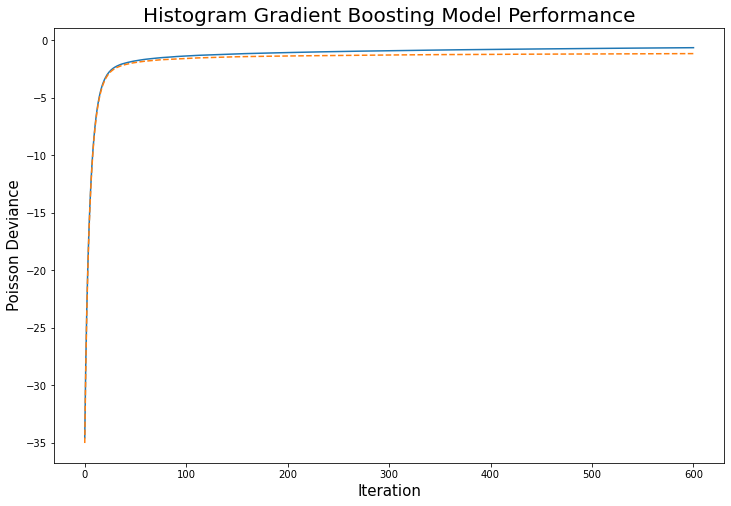

In [59]:
f,ax = plt.subplots(1,figsize=(12,8))
ax.plot(hgbr.train_score_)
ax.plot(hgbr.validation_score_, '--')
ax.set_ylabel('Poisson Deviance',fontsize=15)
ax.set_xlabel('Iteration',fontsize=15)
ax.set_title('Histogram Gradient Boosting Model Performance',fontsize=20)
plt.savefig('plots/tree_methods/hgbr_performance.png')
plt.show()

In [60]:
hgbr_train_pred = hgbr.predict(X_train_standardized)
hgbr_test_pred = hgbr.predict(X_test_standardized)

print(mean_squared_error(y_test, hgbr_test_pred))
print(mean_squared_error(y_test, hgbr_test_pred, squared=False))
print(mean_absolute_error(y_test, hgbr_test_pred))


421.1323819322453
20.521510225425548
13.20740506028541


In [61]:
hgbr_test_pred.max(), y_test.max()

(922.9950505476787, 843.0)

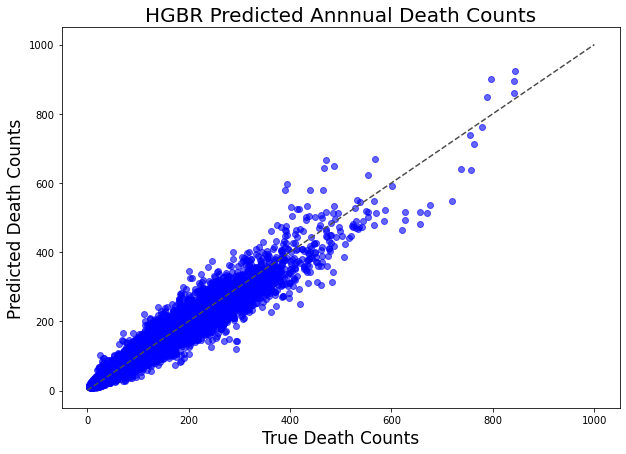

In [62]:
hgbr_test_score=hgbr.score(X_test_standardized, y_test)

plt.figure(figsize=(10,7))
plt.scatter(y_test,hgbr_test_pred,color='blue',alpha=0.6) 
plt.plot([0, 1000], [0, 1000], ls="--", c=".3")
plt.title("HGBR Predicted Annnual Death Counts",fontsize=20) #+ ': $R^2$=' + str(np.round(hgbr_test_score,4)), fontsize=20)
plt.ylabel("Predicted Death Counts", fontsize=17)
plt.xlabel("True Death Counts", fontsize=17)
plt.savefig('plots/tree_methods/hgbr_pred.png')
plt.show()

In [10]:
# hgbr_result = permutation_importance(hgbr, X_test_standardized, y_test, n_repeats=10,
#                                 random_state=42, n_jobs=2)
ys1 = ['CVD','Population','Age','Owner Occ (%)',
       'Winter Temp (K)','Stroke', 'Med House Income',
       'Summer Temp (K)','Year: 2011','Summer $PM_{2.5}$',
       '# of ICU Days', 'Race: Hispanic',
       'Malignant Neoplasms','Race: Black', 
      'Race: White', 'Race: Other', 
      'Mean BMI','Race: Asian',
       'Spring Ozone', 'Winter $NO_2$']


sorted_idx2 = hgbr_result.importances_mean.argsort()
plt.subplots(1,figsize=(20,14))
plt.boxplot(hgbr_result.importances[sorted_idx2].T[:,-20:],
            vert=False,labels= ys1[::-1]) #labels=np.array(X_test_standardized.columns)[sorted_idx2][-20:]) #
plt.title("HGBR Permutation Importance (Test Set)",fontsize=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('plots/tree_methods/hgbr_perm_importance.png',dpi=300)
plt.tight_layout()

HGBR without CVD

In [9]:
cs = ['year_2011','year_2012','year_2013','year_2014','year_2015']

non_binary_preds2 = ['sex','mean_age','population',
       'poverty',  'medianhousevalue', 
       'medhouseholdincome', 'pct_owner_occ',  'education',
       'smoke_rate', 'mean_bmi', 'race_1', 'race_2','race_3', 'race_4', 'race_5', 'race_6',
        'ICU_DAY', 'CCI_DAY', 'LOS',
       'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25',
       'COPD_pdx2dx_25', 'DM_pdx2dx_25',
       'Stroke_pdx2dx_25',  'neo_140_149', 
        'malignant_neoplasms','neo_210_229',
        'pm25_summer_4y_avg', 'pm25_winter_4y_avg', 
       'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
       'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
       'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
       'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
       'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

x_col2 = non_binary_preds2 + cs
y_col = 'deaths_next_year'

# split into train and test and standardize
X_train_standardized2, y_train_standardized2, X_test_standardized2, y_test_standardized2, scaler2 = split_and_standardize2(df_train2, x_col2, y_col, non_binary_preds2)

hgbr2 = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.1, 
                                     max_bins=250,
                                     max_depth=8,
                                     l2_regularization=0.1,
                                    max_iter=600)

hgbr2.fit(X_train_standardized2, y_train_standardized2)
print(hgbr2.score(X_test_standardized2, y_test_standardized2))
print(hgbr2.score(X_train_standardized2, y_train_standardized2))

0.9445507652554361
0.9801260880127459


In [11]:
hgbr_result = permutation_importance(hgbr2, X_test_standardized2, y_test_standardized2, n_repeats=10,
                                random_state=42, n_jobs=2)

ys1 = ['Diabetic','Population', 'Ave Age','Stroke', 'Benign Neoplasms','COPD',
       'Owner Occ (%)', 'Winter Temp (K)','# of ICU Days',
      'Alzheimers','Summer Temp (K)','Med House Income',
       'Race: Other','Race: Hispanic','Year: 2011','Summer $PM_{2.5}$','Race: White', 
       'Race: Black','Parkinsons','Race: Asian'] #'Incomplete Education (%)'


sorted_idx2 = hgbr_result.importances_mean.argsort()
plt.subplots(1,figsize=(20,14))
plt.boxplot(hgbr_result.importances[sorted_idx2].T[:,-20:],
            vert=False,labels= ys1[::-1]) #labels=np.array(X_test_standardized.columns)[sorted_idx2][-20:]) #
plt.title("HGBR Permutation Importance without CVD (Test Set)",fontsize=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.savefig('plots/tree_methods/hgbr_perm_importance_no_cvd.png',dpi=300)
plt.tight_layout()

In [73]:
def find_high_deaths(df_test, model, x_col, n):
    final_X_test,scaler_x = standardize(x_col, df_test[x_col])
    final_y_test = df_test['deaths_next_year']

    final_test_pred = model.predict(final_X_test)
    df_test['death_pred'] = final_test_pred
    df_test['change_in_deaths'] = ((df_test.death_pred - df_test.death) / df_test.death).values
    high_deaths = df_test.sort_values(by='death_pred', ascending=False)[:n]

    return high_deaths

In [74]:
# hgbr_high_deaths = find_high_deaths(df_test,hgbr, x_col,10)
# hgbr_high_deaths[['statecode','zip','death_pred','death', 'age', 'population', 'CVD_pdx2dx_25']+races]

In [76]:
import seaborn as sns
# count_cols = ['CVD_pdx2dx_25','ICU_DAY', 'COPD_pdx2dx_25', 'DM_pdx2dx_25',
#        'Stroke_pdx2dx_25']
# ls = ['CVD','ICU DAYs (#)', 'COPD', 'Diabetes',
#        'Stroke']


# f,axes = plt.subplots(1,2,figsize=(15,8),sharey=True)
# sns.boxplot(data=df_test[count_cols], orient="h", palette="Set2",ax=axes[0])
# sns.boxplot(data=hgbr_high_deaths[count_cols], orient="h", palette="Set2",ax=axes[1])
# # sns.despine(offset=10, trim=True)
# axes[0].set_xlabel('Counts',fontsize=12)
# axes[0].set_title('All Zipcodes',fontsize=15)
# axes[0].set_yticklabels(ls)

# axes[1].set_xlabel('Counts',fontsize=12)
# axes[1].set_title('Zipcodes with Highest Predicted Death Counts (N=10)',fontsize=15)
# plt.suptitle('Cause-Specific Hopitalizations in 2016 Test Data Cohort',fontsize=20)
# plt.savefig('ghbr_high_death_plot.png',dpi=300)
# plt.show()

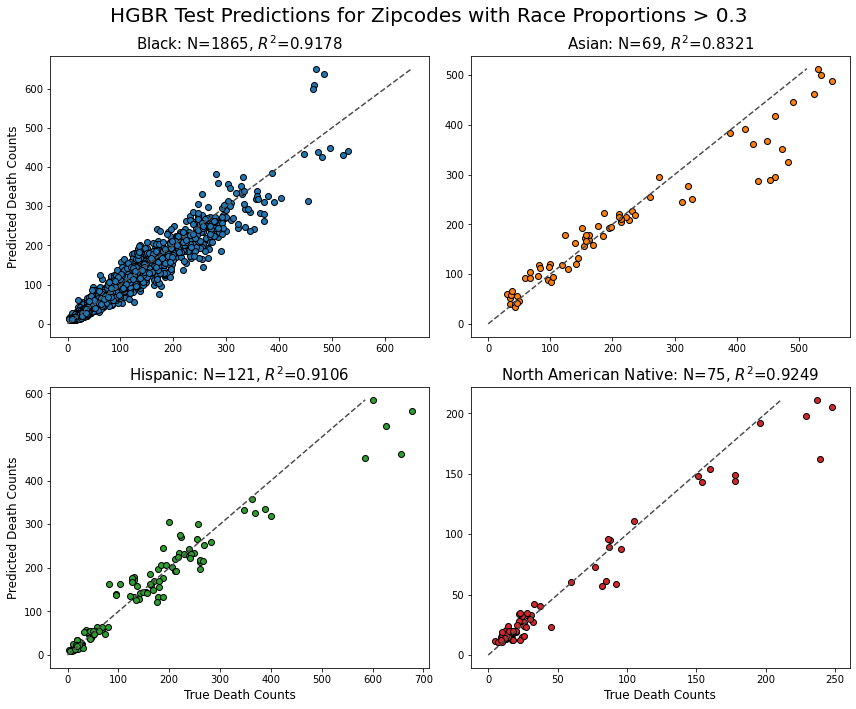

In [78]:
races = ['race_2','race_4','race_5','race_6']
race_names = [ 'Black','Asian','Hispanic','North American Native']
race_dfs = []
preds = []
true = []
r2_scores = []
n = []

# get index of X_test set and groupby zipcode - predict on average (over 5 years)
df_test2 = df_train2.loc[list(X_test_standardized.index)]
# df_test2_means = df_test2.groupby(['zip']).mean()

for i,race in enumerate(races):
    df = df_test2[df_test2[race] >= 0.3]
    if df.shape[0] != 0:
        X_test3 = df[x_col]
        X_test3[non_binary_preds] = scaler1.transform(df[non_binary_preds]) # X_test_standardized.loc[list(df.index.values),:]
        X_test3[cs]=1
        y_test3 = df['deaths_next_year'] # y_test[list(df.index.values)]
        temp_pred  = hgbr.predict(X_test3)
        true.append(y_test3)
        preds.append(temp_pred)
        r2_scores.append(r2_score(temp_pred, y_test3))
        n.append(X_test3.shape[0])
  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
f, axes = plt.subplots(2,2, figsize=(12, 10))
axes = axes.ravel()
for i in range(4):
    axes[i].scatter(true[i], preds[i], c=colors[i],edgecolors='black')
    axes[i].plot([0, preds[i].max()], [0, preds[i].max()], ls="--", c=".3")
    if i == 2 or i == 3:
        axes[i].set_xlabel('True Death Counts',fontsize=12)
    if i == 0 or i == 2:
        axes[i].set_ylabel('Predicted Death Counts',fontsize=12)
    axes[i].set_title(race_names[i] + ': N='+ str(n[i])+ ', $R^2$=' + str(np.round(r2_scores[i],4)), fontsize=15)

plt.suptitle('HGBR Test Predictions for Zipcodes with Race Proportions > 0.3',fontsize=20)
plt.tight_layout()

plt.savefig('hgbr_race_preds_test.png')
plt.show()

In [79]:
hgbr_lime = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.1, 
                                     max_bins=250,
                                     max_depth=8,
                                     l2_regularization=0.3,
                                    max_iter=600)
hgbr_lime.fit(X_train2, y_train2)
print(hgbr_lime.score(X_test2, y_test2))
print(hgbr_lime.score(X_train2, y_train2))

0.9406987112557978
0.9811387728266842


In [12]:
# df_train2.iloc[X_test2[y_test2 > 800].index]

In [81]:
i = 69445
n=10

hgbr_lime_ls_high = explain_local(X_train2, X_test2, x_col, hgbr_lime, i,n)

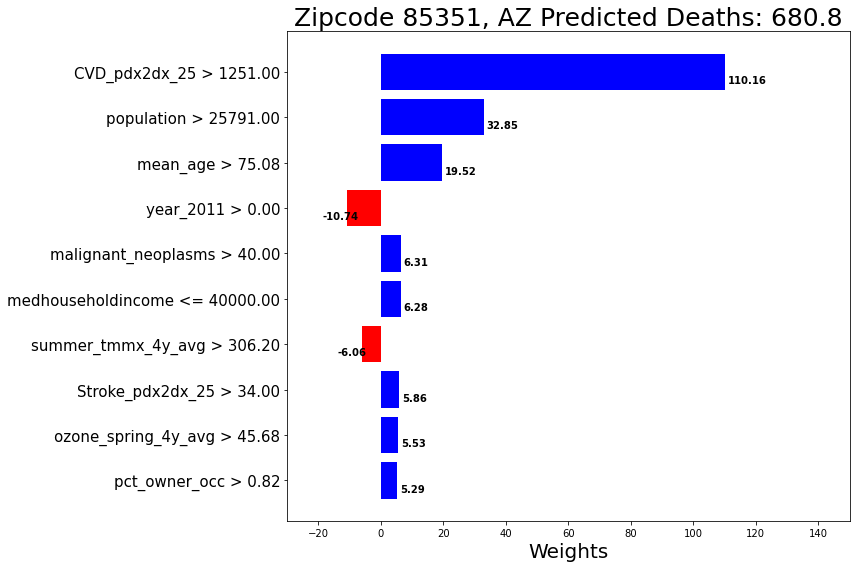

In [83]:
lime_preds = ['CVD_pdx2dx_25','population','mean_age','year_2011',
              'malignant_neoplasms','medhouseholdincome','summer_tmmx_4y_avg',
              'Stroke_pdx2dx_25','ozone_spring_4y_avg',
              'pct_owner_occ']

ind = df_train2.loc[i,:][lime_preds].index
vals = df_train2.loc[i,:][lime_preds].values
# gbr_labels_high = [lime_cols[i]+ ': '+str(round(vals[i],2)) for i in range(10)]
hgbr_labels_high = [i[0] for i in hgbr_lime_ls_high.as_list()]

# get lime weights
hgbr_lime_high = hgbr_lime_ls_high.as_list()
hgbr_weights_high = [hgbr_lime_high[i][1] for i in range(len(hgbr_lime_high))]

colors = []
for j in hgbr_weights_high:
    if j <  0:
        colors.append('red')
    else:
        colors.append('blue')

title='Zipcode '+ str(df_train.loc[[i]].zip.values[0]) +', '+ df_train2.loc[[i]].statecode.values[0]+' Predicted Deaths: '+ str(round(hgbr_lime_ls_high.predicted_value,2))
save_lab='hgbr_lime_high_v2.png'
xlim=(-30,150)
plot_lime(hgbr_weights_high,hgbr_labels_high,title,colors,save_lab,xlim)

In [13]:
# df_train2.iloc[X_test2[y_test2 <4].index]

In [85]:
i = 11772
n=10

hgbr_lime_ls_low = explain_local(X_train2, X_test2, x_col, hgbr_lime, i,n)

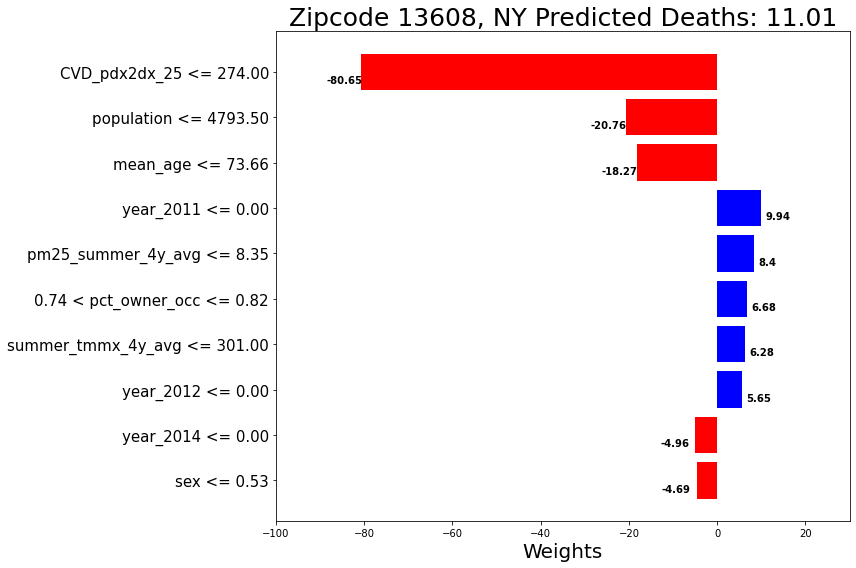

In [86]:
lime_preds = ['CVD_pdx2dx_25','population','mean_age','year_2011',
              'pm25_summer_4y_avg','pct_owner_occ',
              'summer_tmmx_4y_avg',
              'year_2012','year_2014','sex']


ind = df_train2.loc[i,:][lime_preds].index
vals = df_train2.loc[i,:][lime_preds].values
hgbr_labels_low = [i[0] for i in hgbr_lime_ls_low.as_list()]

# get lime weights
hgbr_lime_low = hgbr_lime_ls_low.as_list()
hgbr_weights_low = [hgbr_lime_low[i][1] for i in range(len(hgbr_lime_low))]

colors = []
for j in hgbr_weights_low:
    if j <  0:
        colors.append('red')
    else:
        colors.append('blue')

title='Zipcode '+ str(df_train2.loc[[i]].zip.values[0])+', '+ df_train2.loc[[i]].statecode.values[0]+' Predicted Deaths: '+ str(round(hgbr_lime_ls_low.predicted_value,2))
save_lab='hgbr_lime_low_v2.png'
xlim=(-100,30)
plot_lime(hgbr_weights_low,hgbr_labels_low,title,colors,save_lab,xlim)

Robustness

In [87]:
hgbr_params = {'lr':0.1,
          'max_bins':250,
          'max_iter':600,
          'max_depth':4,
          'l2':0.3,
          'loss':'poisson'}


def build_hgbr_model(params):
    lr = params['lr']
    max_bins = params['max_bins']
    max_iter = params['max_iter']
    max_depth = params['max_depth']
    loss = params['loss']
    l2 = params['l2']
    
    hgbr_model = HistGradientBoostingRegressor(loss=loss, learning_rate=lr, 
                                     max_bins=max_bins,
                                     max_depth=max_depth,
                                     l2_regularization=l2,
                                    max_iter=max_iter)
    return hgbr_model



hgbr_train_r2s, hgbr_test_r2, hgbr_train_mse, hgbr_test_mse, hgbr_train_preds, hgbr_test_preds = check_robustness(df_train2, x_col,y_col,hgbr_params,build_hgbr_model)

0.9698685033051341 0.940385542021035
completed round
0.9694855870128469 0.9454917430077078
completed round
0.9698833585999527 0.9448112264214625
completed round
0.9694576050813235 0.9442963108611399
completed round
0.969622076855804 0.943881868897521
completed round
0.9697110224135179 0.9445733412677946
completed round
0.9692866090231097 0.944138601041395
completed round
0.9691043169655309 0.9419721800370775
completed round
0.9692730785930034 0.9444219532774493
completed round
0.9694214053618055 0.9438909368063182
completed round


In [88]:
htest_upper_bound = np.array(hgbr_test_preds).max(axis=0)
htest_lower_bound = np.array(hgbr_test_preds).min(axis=0)
htest_mean = np.array(hgbr_test_preds).mean(axis=0)

In [122]:
labs = ['hgbr train r2','hgbr test r2','hgbr train mse','hgbr test mse']
for i,s in enumerate([hgbr_train_r2s, hgbr_test_r2, hgbr_train_mse, hgbr_test_mse]):
    print(labs[i],' : ',np.mean(s))

print('hgbr rmse : ',np.mean([np.sqrt(i) for i in hgbr_test_mse]))
print('hgbr r2 std : ',np.std(hgbr_test_r2))
print('hgbr mse std :',np.std(hgbr_test_mse))
print('(min,max r2): ',np.min(hgbr_test_r2),np.max(hgbr_test_r2))
print('(min,max mse): ',np.min(hgbr_test_mse),np.max(hgbr_test_mse))

hgbr train r2  :  0.9695113563212028
hgbr test r2  :  0.94378637036389
hgbr train mse  :  240.54776065756215
hgbr test mse  :  448.4018721126589
hgbr rmse :  21.170827996121986
hgbr r2 std :  0.0014227787764726808
hgbr mse std : 18.81350929786981
(min,max r2):  0.940385542021035 0.9454917430077078
(min,max mse):  415.46619333861116 476.4405038457615


In [14]:
# print(pd.DataFrame([np.sqrt(i) for i in hgbr_test_mse]).describe(), '\n')
# print(pd.DataFrame(hgbr_test_mse).describe(), '\n')
print(pd.DataFrame(hgbr_test_r2).describe(), '\n')

# Appendix
- Adaboost

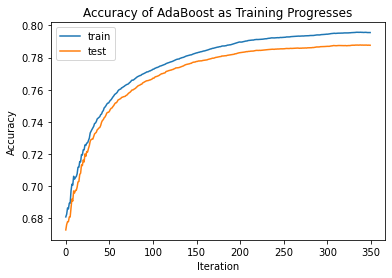

In [16]:
fitted_ada = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=350,
    learning_rate=0.05).fit(X_train_standardized, y_train)

train_scores = list(fitted_ada.staged_score(X_train_standardized, y_train))
test_scores = list(fitted_ada.staged_score(X_test_standardized, y_test))

plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Accuracy of AdaBoost as Training Progresses")
plt.legend()

max(train_scores), max(test_scores)

f, ax = plt.subplots(1, figsize=(8,5))
ax.plot(train_scores,label='train')
ax.plot(test_scores,label='test')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title("AdaBoost Accuracy")
plt.legend()
plt.show()
f.savefig('adaboost_results.png')

gbr race preds

In [ ]:
# gbr race preds plot for non-standardized data
races = ['race_2','race_4','race_5','race_6']
race_names = [ 'Black','Asian','Hispanic','North American Native']
race_dfs = []
preds = []
true = []
r2_scores = []
n = []
gbr_params = {'lr':0.1,
          'n_trees':400,
          'max_depth':6,
          'sprop':1,
          'max_feats':'sqrt'}

# get index of X_test set and groupby zipcode - predict on average (over 5 years)
df_test2 = df_train2.loc[list(X_test2.index)]
df_test2_means = df_test2.groupby(['zip'])[x_col+[y_col]].mean()

for i,race in enumerate(races):
    df = df_test2_means[df_test2_means[race] >= 0.3] # df_test2[race].mean()

    if df.shape[0] != 0:
        X_test3 = df[x_col]
        y_test3 = df['deaths_next_year'] # y_test[list(df.index.values)]
        temp_pred  = gbr_model.predict(X_test3)
        true.append(y_test3)
        preds.append(temp_pred)
        r2_scores.append(r2_score(temp_pred, y_test3))
        n.append(X_test3.shape[0])
  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
f, axes = plt.subplots(2,2, figsize=(12, 10))
axes = axes.ravel()
for i in range(4):
    axes[i].scatter(true[i], preds[i], c=colors[i],edgecolors='black')
    axes[i].plot([0, preds[i].max()], [0, preds[i].max()], ls="--", c=".3")
    if i == 2 or i == 3:
        axes[i].set_xlabel('True Death Counts',fontsize=12)
    if i == 0 or i == 2:
        axes[i].set_ylabel('Predicted Death Counts',fontsize=12)
    axes[i].set_title(race_names[i] + ': N='+ str(n[i])+ ', $R^2$=' + str(np.round(r2_scores[i],4)), fontsize=15)

plt.suptitle('GBR Test Predictions for Zipcodes with Race Proportions > 0.3',fontsize=20)
plt.tight_layout()

# plt.savefig('race_preds.png')
plt.show()

In [203]:
labels=['CVD','Diabetic','Stroke','Parkinson','COPD','ICU Days (#)', 'popdensity',
       'North American native (%)','Alzheimer','Age', 'Dementia', 'Summer PM2.5',
       'Summer Temperature','Winter Temperature','Malignant Neoplasms: Unspecified',
        'Asian (%)', 'Malignant Neoplasm:Lymphatic Tissue','Malignant Neoplasm: Genitourinary',
       'Female (%)','Black(%)']

labels = ['Female (%)','Age',
       'Poverty (%)', 'Population Density', 'Median House Value', 
       'Med Household Income', 'Owner Occpancy (%)',  'Education (%)',
       'Smoke Rate', 'Mean Bmi', 'White(%)', 'Black(%)',
       'Other Race (%)', 'Asian (%)', 'Hispanic (%)', 'North American Native (%)',
         'ICU Days', 'CCI Day', 'LOS',
       'Parkinson', 'Alzheimer', 'Dementia',
       'COPD', 'Diabetic',
       'Stroke', 'CVD', 'Malignant Neoplasm: Oral',
       'Malignant Neoplasm: Digetive', 'Malignant Neoplasm:Respiratory',
        'Malignant Neoplasm:Bone', 'Malignant Neoplasm:Genitourinary',
       'Malignant Neoplasm:Unspecified', 'Malignant Neoplasm:Lymphatic', 'Bengign Neoplasm', 'Carcinoma in Situ',
       'Neoplasm: Uncertain Behavior', 'Neoplasm: Unspecified Nature', 
        'Summer PM2.5', 'Winter PM2.5',
       'Fall PM2.5', 'Spring PM2.5', 'Summer Ozone',
       'Winter Ozone', 'Fall Ozone', 'Spring Ozone',
       'Summer NO2', 'Winter NO2', 'Fall NO2',
       'Spring NO2', 'Summer Temperature', 'Summer Humidity',
       'Winter Temperature', 'Winter Humidity']

In [ ]:
zips = np.unique(df_train.zip)
zips_sub = list(np.random.choice(zips,300))
df_train_sub2 = df_train[df_train.zip.isin(zips_sub)]
# df_train_sub = df_train[df_train.AYEAR==2015]

X_train_sub2, y_train_sub2, X_test_sub2, y_test_sub2 = split_and_standardize(df_train_sub2, x_col, y_col, 
                                                                         non_binary_preds, s=True)

gbr_test_pred_sub = gbr_model.predict(X_test_sub2)

# gbr_train_pred_sub = gbr_model.predict(X_train_sub)
gbr_test_pred = gbr_model.predict(X_test_standardized)
explainer_test = shap.TreeExplainer(gbr_model)

shap_values_test = explainer_test.shap_values(X_test_standardized)
np.abs(shap_values_test.sum(1) + explainer_test.expected_value - gbr_test_pred).max()
f,ax = plt.subplots(1,1, figsize=(10,8))
shap.summary_plot(shap_values_test,X_test_standardized,show=False)
# ax.set_yticklabels(labels=labels[:20])
plt.title("GBR SHAP Values (Test Set)", fontsize=20)
# plt.yticks()
# plt.savefig('gbr_summary_shap.png')
plt.show()

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'blue','red')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,15),legend=False)
    ax.set_xlabel("SHAP Value (Blue = Positive Impact)")
    
ys = ['no2_fall_4y_avg','no2_winter_4y_avg','no2_spring_4y_avg','no2_summer_4y_avg']
x_labs = ['Fall NO2','Winter NO2','Spring NO2','Summer NO2']
y_labs = ['SHAP Value for Fall NO2','SHAP Value for Winter NO2',
          'SHAP Value for Spring NO2','SHAP Value for Summer NO2']

f, axes = plt.subplots(2,2, figsize=(17, 12))
axes = axes.ravel()

# make plots colored by each of the top three possible interacting features
for j in range(4):
    inds = shap.approximate_interactions(ys[j], shap_values_test, X_test_standardized)
    shap.dependence_plot(ys[j], shap_values_test, X_test_standardized, 
                        ax=axes[j], show=False)  
    axes[j].set_xlabel(x_labs[j], fontsize=15)
    axes[j].set_ylabel(y_labs[j], fontsize=15)
plt.suptitle('NO2 Interaction Plots', fontsize=25)
plt.tight_layout()
plt.savefig('no2_shaps.png')
plt.show()

ys = ['pm25_fall_4y_avg','pm25_winter_4y_avg','pm25_spring_4y_avg','pm25_summer_4y_avg']
x_labs = ['Fall PM2.5','Winter PM2.5','Spring PM2.5','Summer PM2.5']
y_labs = ['SHAP Value for Fall PM2.5','SHAP Value for Winter PM2.5',
          'SHAP Value for Spring PM2.5','SHAP Value for Summer PM2.5']

f, axes = plt.subplots(2,2, figsize=(17, 12))
axes = axes.ravel()

# make plots colored by each of the top three possible interacting features
for j in range(4):
    inds = shap.approximate_interactions(ys[j], shap_values_test, X_test_standardized)
    shap.dependence_plot(ys[j], shap_values_test, X_test_standardized, 
                        ax=axes[j], show=False)  
    axes[j].set_xlabel(x_labs[j], fontsize=15)
    axes[j].set_ylabel(y_labs[j], fontsize=15)
plt.tight_layout()
# plt.savefig('pm25_shaps.png')
plt.show()

ys = ['summer_rmax_4y_avg','winter_rmax_4y_avg']
x_labs = ['Summer Humidity','Winter Humidity']
y_labs = ['SHAP Value for Summer Humidity','SHAP Value for Winter Humidity']

f, axes = plt.subplots(2,1, figsize=(15, 10))
axes = axes.ravel()

# make plots colored by each of the top three possible interacting features
for j in range(2):
    inds = shap.approximate_interactions(ys[j], shap_values_test, X_test_standardized)
    shap.dependence_plot(ys[j], shap_values_test,X_test_standardized,  dot_size=12,
                        ax=axes[j], show=False)  
    axes[j].set_xlabel(x_labs[j], fontsize=15)
    axes[j].set_ylabel(y_labs[j], fontsize=15)
plt.suptitle('Humidity Interaction Plots', fontsize=20)
# plt.tight_layout()
plt.savefig('rmax_shaps.png')
plt.show()

ys = ['winter_tmmx_4y_avg','summer_tmmx_4y_avg']
x_labs = ['Winter Temperature  (K)','Summer Temmperature (K)']
y_labs = ['SHAP Value for Winter Temperature','SHAP Value for Summer Temperature']
titles=['Winter Temperature  (K)','summerTemmperature (K)']

f, axes = plt.subplots(2,1, figsize=(15, 12))
axes = axes.ravel()

# make plots colored by each of the top three possible interacting features
for j in range(2):
    inds = shap.approximate_interactions(ys[j], shap_values_test,X_test_standardized)
    shap.dependence_plot(ys[j], shap_values_test,X_test_standardized, dot_size=12,
                        ax=axes[j], show=False)  
    axes[j].set_xlabel(x_labs[j], fontsize=15)
    axes[j].set_ylabel(y_labs[j], fontsize=15)
plt.suptitle('Temperature Interaction Plots', fontsize=20)
plt.tight_layout()
plt.savefig('temp_shaps.png')
plt.show()